<a href="https://colab.research.google.com/github/jaimegonzalezc/KC-NLP-Practica/blob/main/PracticaNLP-1-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Natural Language Processing - KeepCoding
## Introducción
Para evaluar los conocimientos adquiridos en el módulo de Procesamiento de lenguaje natural, se nos pide realizar un estudio completo sobre reviews de productos de Amazon. Este estudio constará de las siguientes fases:
1. Descarga y EDA
2. Preprocesado
3. Entrenamiento/Test
4. Métricas y conclusiones

Por facilidad en la correción, estos cuatro ejercicios se entregarán en cuatro notebooks independientes.

El objetivo de este proyecto es poner en práctica todos los métodos de análisis, procesado y entrenamiento de modelos de Machine Learning y Deep Learning aplicados al

## 1. Descarga y EDA
En primer lugar vamos a descargar el corpus y a hacer un análisis exploratorio de los datos.

Para este ejercicio se ha seleccionado un conjunto de reseñas de música digital de Amazon.

Por ello, en primer lugar cargamos el dataset:

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

data = pd.read_json('/content/drive/MyDrive/Bootcamp IA/NLP/Práctica/Digital_Music_5.json', lines=True)

Ahora vamos a echar un primer vistazo para empezar a conocer el dataset y entender un poco con qué variables contamos

In [5]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_length
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006",153
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001",100
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003",84
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000",91
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008",714


En primer lugar observamos que el campo con el vamos a trabajar principalmente para el análisis es `reviewText`. Adicionalmente tenemos nuestra variable objetivo `overall` que se trata de el valor de la reseña puntuada del 1 al 5. Ya que son pocas clases, puede ser un buen ejercicio de clasificación. Aunque a mí personalmente me gustan más los problemas de regresión ya que al recibir un valor exacto le veo más utilidad para el mundo real. Más adelante en la práctica se decidirá qué tipo de problema se va a afrontar.  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      64706 non-null  object
 1   asin            64706 non-null  object
 2   reviewerName    64529 non-null  object
 3   helpful         64706 non-null  object
 4   reviewText      64706 non-null  object
 5   overall         64706 non-null  int64 
 6   summary         64706 non-null  object
 7   unixReviewTime  64706 non-null  int64 
 8   reviewTime      64706 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.4+ MB


Vemos que no hay variables vacías y que nuestra variable obejtivo ya tiene un valor numérico. Parece que los datos vienen con un pequeño preprocesado ya que están bastante limpios, seguramente debido a que Amazon no permite incluir una reseña con campos vacíos.

In [4]:
data.describe()

,overall,unixReviewTime
count,64706.000000,6.470600e+04
mean,4.222514,1.151117e+09
std,1.086081,1.279250e+08
min,1.000000,8.937216e+08
25%,4.000000,1.056931e+09
50%,5.000000,1.128989e+09
75%,5.000000,1.245024e+09
max,5.000000,1.406074e+09


Describiendo los valores numérciso, vemos que la media de las reseñas ens 4,22 lo cual es bastante alto en general teniendo en cuenta que se comprenden en un rango 1-5. Otro valor que me llama la atención es que más de la mitad de las reseñas son un 5. Vemos también que no encontramos ningún tipo de outlier ya que los valores máximos se comprenden en los rangos esperados.

Siguiendo con el análisis, vamos a ver la cardinalidad del vocabulario:

In [5]:
vocab = Counter(" ".join(data['reviewText']).split())
print(f'Cardinalidad del vocabulario: {len(vocab)}')

Cardinalidad del vocabulario: 590938


Trabajamos con 590938 palabras distintas. Vamos a ver ahora la cantidad de reviews por número de estrellas:

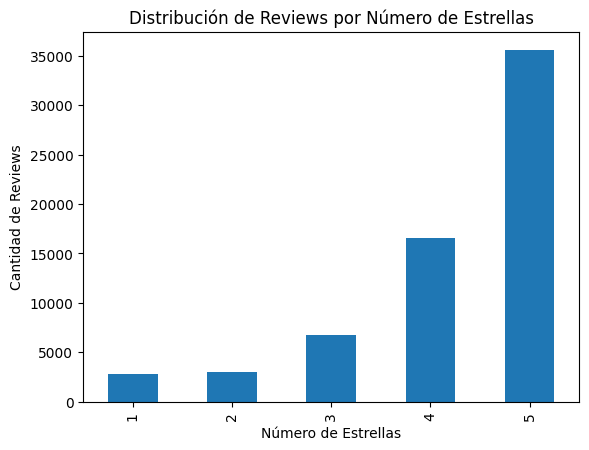

In [6]:
data['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Reviews por Número de Estrellas')
plt.xlabel('Número de Estrellas')
plt.ylabel('Cantidad de Reviews')
plt.show()

Como hemos visto anteriormente con la función describe() vemos que la mayoría de reseñas tienen una puntuación de 5.

Ahora vamos a ver el número de reviews positivas y negativas. El umbral se ha establecido en 3, por lo que reseñas positivas se consideran los valores 4 y 5 y negativas el resto.

In [7]:
data['sentiment'] = data['overall'].apply(lambda x: 'positive' if x > 3 else 'negative')
print(data['sentiment'].value_counts())

sentiment
positive    52116
negative    12590
Name: count, dtype: int64


Vamos a ver ahora los N-grams más frecuentes. En este caso se ha elegido como rango 2-3, por lo que veremos los conjuntos de dos y tres palabras más repetidos en el dataset.

In [9]:
vectorizer = CountVectorizer(ngram_range=(2, 3))
ngrams = vectorizer.fit_transform(data['reviewText'])
ngrams_freq = ngrams.sum(axis=0).A1
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams_freq))
ngrams_freq = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)
print(ngrams_freq[:10])

[('of the', 81421), ('this album', 45850), ('in the', 38838), ('on the', 34626), ('the album', 32163), ('this is', 31254), ('and the', 29271), ('one of', 28795), ('to the', 26034), ('is the', 19433)]


Viendo los 10 N-grams más repetidos, vemos que no hay ninguno de 3 palabras. Esperable ya que es más difícil encontrar conjuntos de 3 palabras repetidos. Estos resultados muestran una gran cantidad de stop-words, que tendremos que eliminar el el preprocesado ya que son palabras que no nos muestran sentimiento alguno.

Ahora sacamos un gráfico de nubes de palabras para ver las más repetidas:

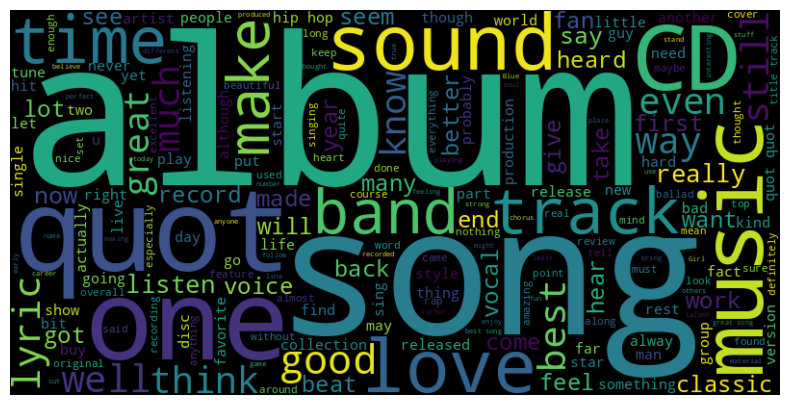

In [10]:
wordcloud = WordCloud(width=800, height=400).generate(" ".join(data['reviewText']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Como es de esperar vemso palabras relacionadas con el mundo de la música como album, CD, song, track...

También encontramos palabras que muestran sentimiento como good, love, great...

A continuación vamos a hacer una visualización en 2 dimensiones de algunos word embeddings calculados con el modelo word2vec. Esto nos va a permitir convertir las palabras del dataset a vectores para poder sacar un conjunto de palabras similares a otras definidas.

En este caso se han escogido las 5 palabras que parecen más repetidas identificadas en la nube de palabras realizada.

En primer lugar se va a ejecutar el modelo Word2Vec ya definido y con la función most_similar se va a sacar las 10 palabras más similares por cada palabra de las 5 definidas.

In [19]:
data['cleaned_text'] = data['reviewText'].apply(lambda x: x.lower().split())
model = Word2Vec(sentences=data['cleaned_text'], vector_size=100, window=5, min_count=1, workers=4)
words = ['album', 'song', 'band', 'sound', 'music']
similar_words = {word: [item[0] for item in model.wv.most_similar(word, topn=10)] for word in words}

Después, tendremos que limitar las dimensiones de los vectores utilizando PCA, para reducir su dimensionalidad a 2 para poder imprimirlos en un gráfico de dos dimensiones.

In [20]:
all_words = sum([[k] + v for k, v in similar_words.items()], [])
word_vectors = np.array([model.wv[word] for word in all_words])
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

Por último, generamos el gráfico y lo mostramos:

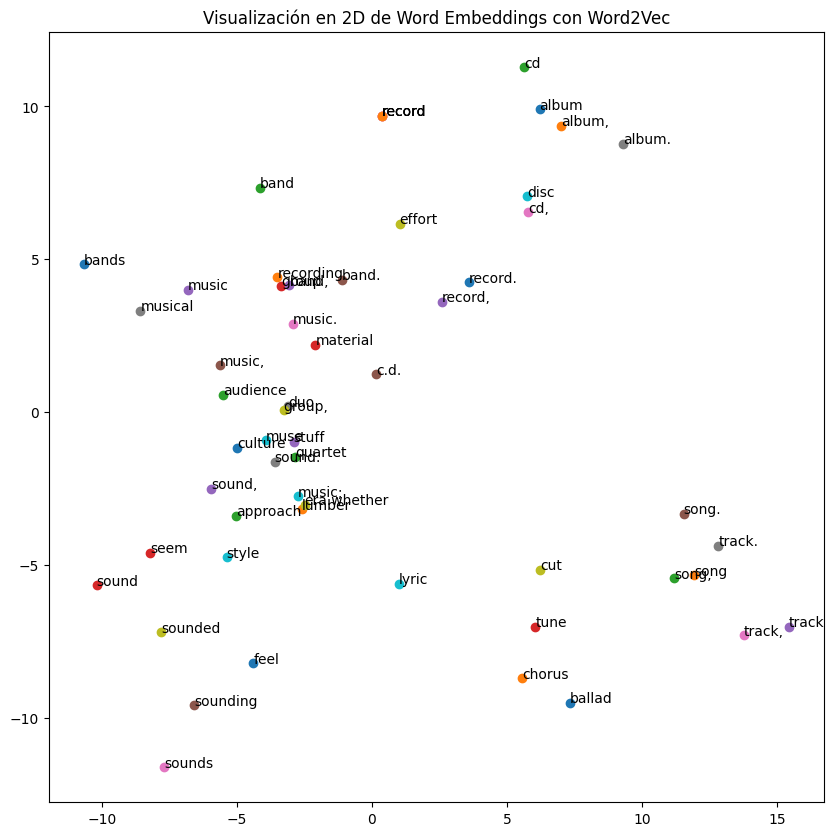

In [21]:
plt.figure(figsize=(10, 10))
for i, word in enumerate(all_words):
    plt.scatter(word_vectors_pca[i, 0], word_vectors_pca[i, 1])
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]))
plt.title('Visualización en 2D de Word Embeddings con Word2Vec')
plt.show()

Viendo el gráfico, se aprecia como el modelo ha predicho relativamente bien el significado de cada palabra y ha encontrado palabras bastante similares. Algo a remarcas es que no ha salido ninguna stop-word.

Otra cosa que se podría mejorar en este gráfico es la eliminación de signos de puntuación, ya que en ocasiones vemos palabras repetidas que aparecen seguidas de un punto o una coma.

Pero esto también es una muestra de la corrección del modelo, ya que encontramos palabras repetidas y se encuentran en la misma parte del mapa y relativamente cerca. Esto lo podemos apreciar a la drecha del gráfico con la palabra `song` apareciendo tres veces en la misma sección del gráfico.

A continuación, se calcula la longitud media de las reseñas:

In [4]:
data['review_length'] = data['reviewText'].apply(lambda x: len(x.split()))
avg_length = data['review_length'].mean()
print(f'Longitud promedio de las reseñas: {avg_length:.2f} palabras')

Longitud promedio de las reseñas: 196.69 palabras


Como conclusiones de la exploración, personalmente creo que es un dataset interesante a la par que desafiante, ya que las reseñas de música se ven influídas no solo por la calidad del producto, sino también por los gustos musicales de cada persona.

Seguramente por eso las reseñas sean tan altas, ya que una persona que compra un disco seguramente sea porque le gusta el artista, más teniendo en cuenta que además se trata de un producto digital, por lo que no influyen cosas como el transporte, la entrega...

Además, me resulta bastante curioso que la media de palabras utilizadas en cada reseña sea tan elevada, de casi 200 palabras por reseña. Esto me sorprende gratamente ya que en mi propia experiencia poniendo reseñas, es frecuente se conciso y utilizar pocas palabras.

Este ha sido el análisis exploratorio sin ningún procesado de la información original. En los siguientes apartados se procesará con más detenimiento el corpus por lo que podrán surgir nuevas conclusiones.